In [1]:
from kf import *

In [2]:
def make_ax():
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_aspect('equal')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel('x', fontsize=10)
    ax.set_ylabel('y', fontsize=10)
    return ax

def draw_trajectory(xs, ax):
    poses = [xs[s] for s in range(len(xs))]
    ax.scatter([e[0] for e in poses], [e[1] for e in poses], s=5, marker='.', color='black')
    ax.plot([e[0] for e in poses], [e[1] for e in poses], linewidth=0.5, color='black')
    
def draw_observations(xs, zlist, ax):
    for s in range(len(xs)):
        if s not in zlist:
            continue
        
        for obs in zlist[s]:
            x, y, theta = xs[s]
            ell, phi = obs[1][0], obs[1][1]
            mx = x + ell * math.cos(theta + phi)
            my = y + ell * math.sin(theta + phi)
            ax.plot([x, mx], [y, my], color='pink', alpha=0.5)
            
def draw(xs, zlist):
    ax = make_ax()
    draw_observations(xs, zlist, ax)
    draw_trajectory(xs, ax)
    plt.show()

In [3]:
def read_data():
    hat_xs = {}
    zlist = {}
    delta = 0.0
    us = {}
    
    with open('log2.txt') as f:
        for line in f.readlines():
            tmp = line.rstrip().split()
            step = int(tmp[1])
            if tmp[0] == 'x':
                hat_xs[step] = np.array([float(tmp[2]), float(tmp[3]), float(tmp[4])]).T
            elif tmp[0] == 'z':
                if step not in zlist:
                    zlist[step] = []
                zlist[step].append((int(tmp[2]), np.array([float(tmp[3]), float(tmp[4]), float(tmp[5])]).T))
            elif tmp[0] == 'delta':
                delta = float(tmp[1])
            elif tmp[0] == 'u':
                us[step] = np.array([float(tmp[2]), float(tmp[3])]).T
                
        return hat_xs, zlist, us, delta

In [4]:
class ObsEdge:
    def __init__(self, t1, t2, z1, z2, xs, sensor_noise_rate=[0.14, 0.05, 0.05]):
        assert z1[0] == z2[0]
        self.t1, self.t2 = t1, t2
        self.x1, self.x2 = xs[t1], xs[t2]
        self.z1, self.z2 = z1[1], z2[1]
        
        s1 = math.sin(self.x1[2] + self.z1[1])
        c1 = math.cos(self.x1[2] + self.z1[1])
        s2 = math.sin(self.x2[2] + self.z2[1])
        c2 = math.cos(self.x2[2] + self.z2[1])
        
        hat_e = self.x2 - self.x1 + np.array([
            self.z2[0] * c2 - self.z1[0] * c1,
            self.z2[0] * s2 - self.z1[0] * s1,
            self.z2[1] - self.z2[2] - self.z1[1] + self.z1[2]
        ])
        while hat_e[2] >= math.pi:
            hat_e[2] -= math.pi * 2
        while hat_e[2] < -math.pi:
            hat_e[2] += math.pi * 2
            
        Q1 = np.diag([(self.z1[0] * sensor_noise_rate[0]) ** 2, sensor_noise_rate[1] ** 2, sensor_noise_rate[2] ** 2])
        R1 = -np.array([[c1, -self.z1[0] * s1, 0],
                                 [s1, self.z1[0] * c1, 0],
                                 [0,                       1, -1]])
        
        Q2 = np.diag([(self.z2[0] * sensor_noise_rate[0]) ** 2, sensor_noise_rate[1] ** 2, sensor_noise_rate[2] ** 2])
        R2 = np.array([[c2, -self.z2[0] * s2, 0],
                                 [s2, self.z2[0] * c2, 0],
                                 [0,                       1, -1]])
        
        Sigma = R1.dot(Q1).dot(R1.T) + R2.dot(Q2).dot(R2.T)
        Omega = np.linalg.inv(Sigma)
        
        B1 = -np.array([[1, 0, -self.z1[0] * s1],
                                 [0, 1, self.z1[0] * c1],
                                 [0, 0,                      1]])
        B2 = np.array([[1, 0, -self.z2[0] * s2],
                                 [0, 1, self.z2[0] * c2],
                                 [0, 0,                     1]])
        
        self.omega_upperleft = B1.T.dot(Omega).dot(B1)
        self.omega_upperright = B1.T.dot(Omega).dot(B2)
        self.omega_bottomleft = B2.T.dot(Omega).dot(B1)
        self.omega_bottomright = B2.T.dot(Omega).dot(B2)
        
        self.xi_upper = -B1.T.dot(Omega).dot(hat_e)
        self.xi_bottom = -B2.T.dot(Omega).dot(hat_e)

In [5]:
class MotionEdge:
    def __init__(self, t1, t2, xs, us, delta, motion_noise_stds={'nn': 0.19, 'no': 0.001, 'on': 0.13, 'oo': 0.2}):
        self.t1, self.t2 = t1, t2
        self.hat_x1, self.hat_x2 = xs[t1], xs[t2]
        
        nu, omega = us[t2]
        if abs(omega) < 1e-5:
            omega = 1e-5
        
        M = matM(nu, omega, delta, motion_noise_stds)
        A = matA(nu, omega, delta, self.hat_x1[2])
        F = matF(nu, omega, delta, self.hat_x1[2])
        
        Omega = np.linalg.inv(A.dot(M).dot(A.T) + np.eye(3) * 0.0001)
        
        self.omega_upperleft = F.T.dot(Omega).dot(F)
        self.omega_upperright = -F.T.dot(Omega)
        self.omega_bottomleft = -Omega.dot(F)
        self.omega_bottomright = Omega
        
        x2 = IdealRobot.state_transition(nu, omega, delta, self.hat_x1)
        self.xi_upper = F.T.dot(Omega).dot(self.hat_x2 - x2)
        self.xi_bottom = -Omega.dot(self.hat_x2 - x2)

In [16]:
import itertools

def make_edges(hat_xs, zlist):
    landmark_keys_zlist = {}
    
    for step in zlist:
        for z in zlist[step]:
            landmark_id = z[0]
            if landmark_id not in landmark_keys_zlist:
                landmark_keys_zlist[landmark_id] = []
            
            landmark_keys_zlist[landmark_id].append((step, z))
    
    edges = []
    for landmark_id in landmark_keys_zlist:
        step_pairs = list(itertools.combinations(landmark_keys_zlist[landmark_id], 2))
        edges += [ObsEdge(xz1[0], xz2[0], xz1[1], xz2[1], hat_xs) for xz1, xz2 in step_pairs]
    
    return edges, landmark_keys_zlist

def draw_edges(edges, ax):
    for e in edges:
        ax.plot([e.x1[0], e.x2[0]], [e.x1[1], e.x2[1]], color='red', alpha=0.5)
        
def draw_landmarks(ms, ax):
    ax.scatter([m[0] for m in ms.values()], [m[1] for m in ms.values()], s=100, marker="*", color='blue', zorder=100)
        
def draw(xs, zlist, edges, ms={}):
    ax = make_ax()
    draw_observations(xs, zlist, ax)
    draw_trajectory(xs, ax)
    draw_landmarks(ms, ax)
    plt.show()

In [17]:
def add_edge(edge, Omega, xi):
    f1, f2 = edge.t1 * 3, edge.t2 * 3
    t1, t2 = f1 + 3, f2 + 3
    Omega[f1:t1, f1:t1] += edge.omega_upperleft
    Omega[f1:t1, f2:t2] += edge.omega_upperright
    Omega[f2:t2, f1:t1] += edge.omega_bottomleft
    Omega[f2:t2, f2:t2] += edge.omega_bottomright
    xi[f1:t1] += edge.xi_upper
    xi[f2:t2] += edge.xi_bottom

1: 6.970947490317289
2: 4.805858965135045
3: 2.669806808628345
4: 2.035806517003763
5: 1.6293361254615262
6: 1.3078516335219437
7: 1.0504186323759381
8: 0.8440359070983725
9: 0.6786593144437277
10: 0.5461838439931367
11: 0.4400662220250026
12: 0.3550489944306482
13: 0.28691993092818757
14: 0.23230941898623908
15: 0.18852337086703697
16: 0.15340776534311748
17: 0.12523984256906215
18: 0.10264114334868411
19: 0.08450816218081983
20: 0.06995708315816701
21: 0.058279729337473406
22: 0.04890842731436111
23: 0.04138795970544871
24: 0.03535315769121752
25: 0.03051098768020246
26: 0.026626224586599648
27: 0.02350999147246476
28: 0.021010591756720726
29: 0.01900617467394278
30: 0.017398864828793898
31: 0.016110058909409163
32: 0.015076651648287623
33: 0.014248001888473747
34: 0.013583489620752127
35: 0.013050546911544598
36: 0.012623070587163424
37: 0.012280143538869595
38: 0.012005005924444572
39: 0.011784228644911124
40: 0.01160705025429005
41: 0.011464845592791678
42: 0.011350700313248427
43

<IPython.core.display.Javascript object>


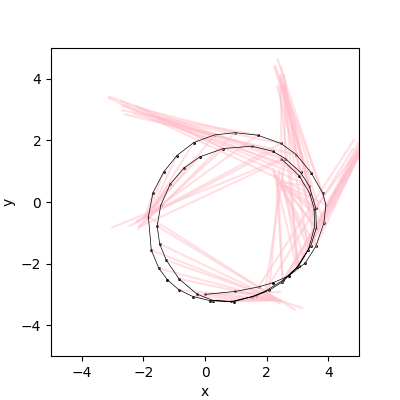

<IPython.core.display.Javascript object>


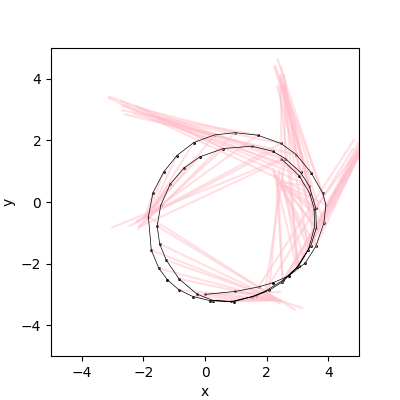

<IPython.core.display.Javascript object>


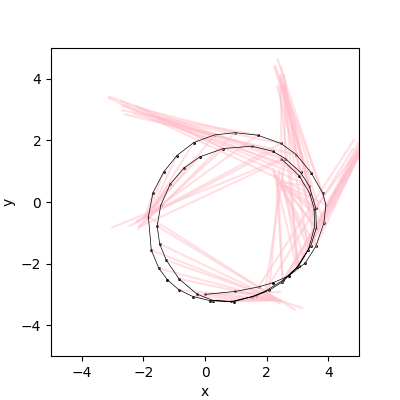

In [18]:
hat_xs, zlist, us, delta = read_data()
dim = len(hat_xs) * 3

for n in range(1, 10000):
    edges, _ = make_edges(hat_xs, zlist)
    
    for i in range(len(hat_xs) - 1):
        edges.append(MotionEdge(i, i + 1, hat_xs, us, delta))
    
    Omega = np.zeros((dim, dim))
    xi = np.zeros(dim)
    Omega[0:3, 0:3] += np.eye(3) * 1000000
    
    for e in edges:
        add_edge(e, Omega, xi)
    
    delta_xs = np.linalg.inv(Omega).dot(xi)
    
    for i in range(len(hat_xs)):
        hat_xs[i] += delta_xs[i *3:(i + 1) * 3]
        
    diff = np.linalg.norm(delta_xs)
    print('{}: {}'.format(n, diff))
    if diff < 0.011:
        draw(hat_xs, zlist, edges)
        break

In [19]:
_, zlist_landmark = make_edges(hat_xs, zlist)

In [26]:
class MapEdge:
    def __init__(self, t, z, head_t, head_z, xs, sensor_noise_rate=[0.14, 0.05, 0.05]):
        self.x = xs[t]
        self.z = z
        
        self.m = self.x + np.array([
            z[0] * math.cos(self.x[2] + z[1]),
            z[0] * math.sin(self.x[2] + z[1]),
            - xs[head_t][2] + z[1] + head_z[1] - z[2] + head_z[2]
        ]).T
        
        while self.m[2] >= math.pi:
            self.m[2] -= math.pi * 2
        while self.m[2] < -math.pi:
            self.m[2] += math.pi * 2
            
        Q1 = np.diag([(self.z[0] * sensor_noise_rate[0]) ** 2, sensor_noise_rate[1] ** 2, sensor_noise_rate[2] ** 2])
        
        s1 = math.sin(self.x[2] + self.z[1])
        c1 = math.cos(self.x[2] + self.z[1])
        R = np.array([[-c1, self.z[0] * s1, 0],
                               [-s1, -self.z[0] * c1, 0],
                               [0,                        -1, 1]])
        
        self.Omega = R.dot(Q1).dot(R.T)
        self.xi = self.Omega.dot(self.m)

<IPython.core.display.Javascript object>


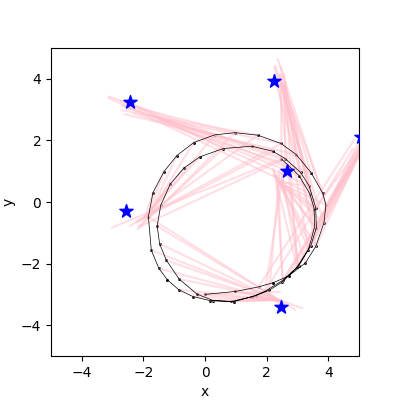

In [27]:
ms = {}
for landmark_id in zlist_landmark:
    edges = []
    head_z = zlist_landmark[landmark_id][0]
    for z in zlist_landmark[landmark_id]:
        edges.append(MapEdge(z[0], z[1][1], head_z[0], head_z[1][1], hat_xs))
    
    Omega = np.zeros((3, 3))
    xi = np.zeros(3)
    for e in edges:
        Omega += e.Omega
        xi += e.xi
    
    ms[landmark_id] = np.linalg.inv(Omega).dot(xi)

draw(hat_xs, zlist, edges, ms)